In [1]:
import stanza
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

In [2]:
column_names = ['Review', 'Label']
df = pd.read_csv('yelp_labelled.txt', delimiter='\t', names=column_names)

In [3]:
df

,Review,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


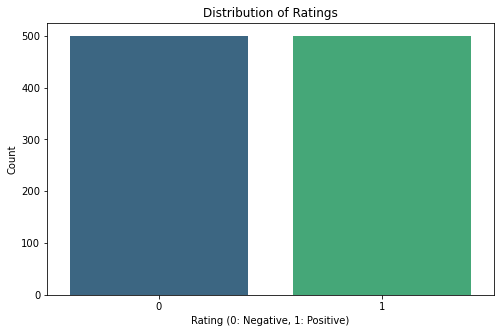

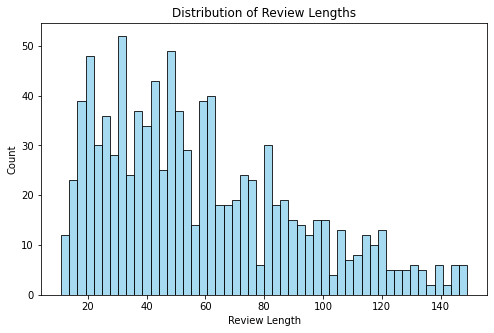

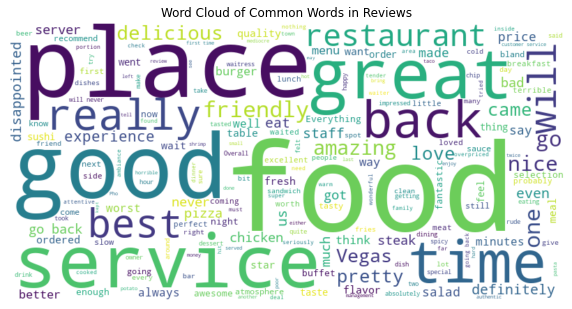

Most Common Words in Reviews:
.: 819 times
the: 585 times
and: 392 times
,: 364 times
i: 356 times
was: 308 times
!: 251 times
a: 237 times
to: 219 times
is: 174 times


In [6]:
rating_distribution = df['Label'].value_counts()

# Calculate the length of reviews
df['Review_Length'] = df['Review'].apply(len)

# Create a word cloud of the most common words
reviews_text = " ".join(df['Review'])
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(reviews_text)

# Plot the distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Label', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Plot the distribution of review lengths
plt.figure(figsize=(8, 5))
sns.histplot(df['Review_Length'], bins=50, color='skyblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words in Reviews')
plt.show()

# Find the most common words
all_words = " ".join(df['Review']).lower()
tokens = word_tokenize(all_words)
word_freq = Counter(tokens)
most_common_words = word_freq.most_common(10)
print("Most Common Words in Reviews:")
for word, freq in most_common_words:
    print(f"{word}: {freq} times")


In [17]:
df

,Review,Label,Review_Length,Sentiment_Score,Sentiment_Label
0,Wow... Loved this place.,1,24,0.0,0
1,Crust is not good.,0,18,0.0,0
2,Not tasty and the texture was just nasty.,0,41,0.0,0
3,Stopped by during the late May bank holiday of...,1,87,0.0,0
4,The selection on the menu was great and so wer...,1,59,0.0,0
...,...,...,...,...,...
995,I think food should have flavor and texture an...,0,66,0.0,0
996,Appetite instantly gone.,0,24,0.0,0
997,Overall I was not impressed and would not go b...,0,50,0.0,0
998,"The whole experience was underwhelming, and I ...",0,91,0.0,0


In [5]:
df2 = pd.read_csv('SentiWords_1.1.txt', delimiter='\t')

In [6]:
df2[['word', 'pos']] = df2['lemma#PoS'].str.split('#', expand=True)
df2['score'] = df2['prior_polarity_score'].astype(float)

df2 = pd.DataFrame(df2, columns=['word', 'pos', 'score'])

In [7]:
single_word_df = df2[df2['word'].str.split('_').apply(lambda x: len(x) == 1)]
df2

,word,pos,score
0,.22_caliber,a,0.00000
1,.22_calibre,a,0.00000
2,.22-caliber,a,0.00000
3,.22-calibre,a,0.00000
4,.22,n,0.12208
...,...,...,...
155282,zymolytic,a,-0.19821
155283,zymosis,n,0.15754
155284,zymotic,a,-0.08847
155285,zymurgy,n,0.00000


In [11]:
# Define the mapping between SentiWords POS tags and Stanza POS tags
pos_mapping = {
    'n': 'NOUN',
    'a': 'ADJ',
    'r': 'ADV',
    'v': 'VERB',
    # Add more mappings as needed
}
# Create a new column 'stanza_pos' in your SentiWords DataFrame
df2['stanza_pos'] = df2['pos'].map(pos_mapping)

In [8]:
sentiword_lexicon = {}
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma')

2023-09-19 20:48:12 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-09-19 20:48:14 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2023-09-19 20:48:14 INFO: Using device: cpu
2023-09-19 20:48:14 INFO: Loading: tokenize
2023-09-19 20:48:14 INFO: Loading: pos
2023-09-19 20:48:14 INFO: Loading: lemma
2023-09-19 20:48:14 INFO: Done loading processors!


## Task 3


In [9]:
sentiment_lexicon = {}

# Iterate through the DataFrame rows
for index, row in df2.iterrows():
    lemma = row['word'].lower()
    pos_tag = row['pos']
    sentiment_score = row['score']

    # Map WordNet POS tags to Stanza POS tags
    stanza_pos = {'a': 'ADJ', 'n': 'NOUN', 'r': 'ADV', 'v': 'VERB'}.get(pos_tag[0].lower(), 'NOUN')

    # Store in the lexicon
    if lemma not in sentiment_lexicon:
        sentiment_lexicon[lemma] = {}
    sentiment_lexicon[lemma][stanza_pos] = sentiment_score

In [12]:
# Define a function to calculate the sentiment score for a sentence
def calculate_sentence_sentiment(sentence):
    tokens = []
    pos_tags = []
    
    # Tokenize, lemmatize, and POS-tag the sentence
    doc = nlp(sentence)
    for sent in doc.sentences:
        for word in sent.words:
            tokens.append(word.lemma.lower())
            pos_tags.append(word.upos.lower())
    
    # Calculate the sentiment score for each word in the sentence
    sentence_sentiment_score = 0
    for i in range(len(tokens)):
        lemma = tokens[i]
        pos_tag = pos_tags[i]
        
        # Check if the lemma and POS tag are in the lexicon
        if lemma in sentiment_lexicon and stanza_pos in sentiment_lexicon[lemma]:
            sentiment_score = sentiment_lexicon[lemma][stanza_pos]
            sentence_sentiment_score += sentiment_score
    
    # Classify the sentence based on the aggregated sentiment score
    if sentence_sentiment_score > 0:
        return 1  # Positive
    else:
        return 0  # Negative

2023-09-19 20:50:21 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-09-19 20:50:22 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2023-09-19 20:50:22 INFO: Using device: cpu
2023-09-19 20:50:22 INFO: Loading: tokenize
2023-09-19 20:50:22 INFO: Loading: pos
2023-09-19 20:50:22 INFO: Loading: lemma
2023-09-19 20:50:22 INFO: Done loading processors!


Sentiment Label: 1


## Task 4

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [22]:
def classify_sentence(sentence):
    sentiment_score = calculate_sentence_sentiment(sentence)
    return sentiment_score

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through Yelp reviews and classify sentences
for review in df['Review']:
    doc = nlp(review)
    for sent in doc.sentences:
        sentence = sent.text
        true_sentiment = df[df['Review'] == review]['Label'].values[0]
        predicted_sentiment = classify_sentence(sentence)
        true_labels.append(true_sentiment)
        predicted_labels.append(predicted_sentiment)

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculate F1 scores for each class
f1_negative = f1_score(true_labels, predicted_labels, pos_label=0)
f1_positive = f1_score(true_labels, predicted_labels, pos_label=1)

# Print the confusion matrix and F1 scores
print("Confusion Matrix:")
print(confusion)
overall_f1 = f1_score(true_labels, predicted_labels)

# Print the overall F1 score
print("F1 Score:", overall_f1)


Confusion Matrix:
[[155 363]
 [ 99 411]]
F1 Score: 0.6401869158878505


## Task 5

In [104]:
# define a function to get the sentiment of a text
def get_emotion(text):
    doc = nlp(text)
    sentiment = 0
    for sent in doc.sentences:
        sentiment += sent.sentiment
    if len(doc.sentences) >0:
        sentiment /= len(doc.sentences)
    else:
        return 'unprocessable'
    if sentiment >= 1:
        return '1'
    else:
        return '0'

df['Score1'] = df['Review'].apply(get_emotion)

predicted_labels = df['Score1']
true_labels = df['Label']

# Convert the predicted labels to integers
predicted_labels = [int(label) for label in predicted_labels]

confusion = confusion_matrix(true_labels, predicted_labels)

f1_negative = f1_score(true_labels, predicted_labels, labels=[0], average='weighted')
f1_positive = f1_score(true_labels, predicted_labels, labels=[1], average='weighted')

print("Confusion Matrix:")
print(confusion)
overall_f1 = f1_score(true_labels, predicted_labels)

# Print the overall F1 score
print("F1 Score:", overall_f1)

from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

# Calculate F1 scores, precision, and recall for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=[0, 1], average=None)

# Calculate macro F1 score
f1_macro = f1_score(true_labels, predicted_labels, average='macro')

# Calculate micro F1 score
f1_micro = f1_score(true_labels, predicted_labels, average='micro')

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Print F1 scores, precision, and recall for each class
print("\nF1 Score for Negative Class (0):", f1[0])
print("F1 Score for Positive Class (1):", f1[1])

# Print macro and micro F1 scores
print("Macro F1 Score:", f1_macro)
print("Micro F1 Score:", f1_micro)


Confusion Matrix:
[[475  25]
 [  8 492]]
F1 Score: 0.967551622418879
Confusion Matrix:
[[475  25]
 [  8 492]]

F1 Score for Negative Class (0): 0.9664292980671415
F1 Score for Positive Class (1): 0.967551622418879
Macro F1 Score: 0.9669904602430103
Micro F1 Score: 0.967
